# FHN ECG Fitting Demo

Demonstration of the **FitzHugh-Nagumo (FHN) ODE model** applied to ECG beats. 

This notebook visualizes a few example beats to show the quality of FHN fits, complementing the automated pipeline in `pipeline.py`.

## Files Required

Before running, please make sure you have the following file in the **main directory** (not inside `/demo`):
- `data/100_ekg.csv`  

This will be the example ECG data used for fitting.

In [1]:
import numpy as np
import pandas as pd
import neurokit2 as nk
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## FitzHugh-Nagumo ODE functions

In [2]:
def fhn(t, y, a, b, tau, I):
    v, w = y
    dv = v - v**3 / 3 - w + I
    dw = (v + a - b*w) / tau
    return [dv, dw]

def simulate_fhn(params, t_eval):
    a, b, tau, I, v0, w0 = params
    sol = solve_ivp(
        lambda t, y: fhn(t, y, a, b, tau, I),
        [0, t_eval[-1]],
        [v0, w0],
        t_eval=t_eval
    )
    return sol.y[0]

def loss(params, t_eval, ecg_subsampled):
    v_sim = simulate_fhn(params, t_eval)
    return np.sum((v_sim - ecg_subsampled)**2)

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot

In [24]:
# --- Aliev-Panfilov system with step-function epsilon(u) ---
def aliev_panfilov(t, y, a, k, epsilon_low, epsilon_high):
    u, v = y

    # Step function for epsilon
    eps = epsilon_low if u < a else epsilon_high

    du = k * u * (1 - u) * (u - a) - u * v
    dv = eps * (k * u - v)

    return [du, dv]

# --- Simulation wrapper ---
def simulate_ap(params, t_eval):
    a, k, epsilon_low, epsilon_high, u0, v0 = params

    # Check for invalid parameters
    if k <= 0 or epsilon_low <= 0 or epsilon_high <= 0:
        return np.full_like(t_eval, np.inf)

    try:
        sol = solve_ivp(
            lambda t, y: aliev_panfilov(t, y, a, k, epsilon_low, epsilon_high),
            [0, t_eval[-1]],
            [u0, v0],
            t_eval=t_eval,
            method="RK45",
            max_step=0.01,  # small step for sharp QRS spikes
            rtol=1e-6,
            atol=1e-8
        )
    except Exception:
        return np.full_like(t_eval, np.inf)

    # Ensure solver returns full output
    if sol.y.shape[1] != len(t_eval):
        return np.full_like(t_eval, np.inf)

    return sol.y[0]

# --- Loss function for fitting ---
def loss_ap(params, t_eval, ecg_subsampled):
    u_sim = simulate_ap(params, t_eval)
    return np.sum((u_sim - ecg_subsampled)**2)

## Load ECG Data

In [4]:
fs = 360
ecg = pd.read_csv("../data/100_ekg.csv")["MLII"].values

# Detect R peaks
signals, info = nk.ecg_process(ecg, sampling_rate=fs)
rpeaks = info["ECG_R_Peaks"]

# Delineate ECG waves
_, waves = nk.ecg_delineate(ecg, rpeaks, sampling_rate=fs, method="dwt")
waves_df = pd.DataFrame(waves)
waves_df["rpeak"] = rpeaks

## Plot specific indices

In [55]:
# --- Recommended initial parameters ---
params0 = [
    0.05,  # a
    8.0,   # k
    1.0,   # epsilon_low
    0.1,   # epsilon_high
    0.1,   # u0 (normalized ECG initial voltage)
    0.0    # v0 (initial recovery)
]

# --- Bounds for optimization ---
bounds = [
        (0.04, 0.07),   # a
        (3.0, 12.0),   # k
        (0.5, 2.0),    # epsilon_low
        (0.05, 0.2),   # epsilon_high
        (0.0, 1.0),    # u0
        (0.0, 0.2)     # v0
    ]

# --- Example of fitting one beat ---
# res = minimize(loss_ap, params0, args=(t_subsampled, ecg_subsampled), method='L-BFGS-B', bounds=bounds)
# fitted_params = res.x
# u_fit = simulate_ap(fitted_params, t_subsampled)

Fitted parameters for beat 0: [0.07       4.99965538 1.00001087 0.05019284 0.0915899  0.        ]
Fitted parameters for beat 8: [0.04       3.         2.         0.05       0.85021339 0.        ]
Fitted parameters for beat 12: [7.00000000e-02 8.88476654e+00 1.06227565e+00 5.81135719e-02
 8.06508618e-02 4.37958148e-07]


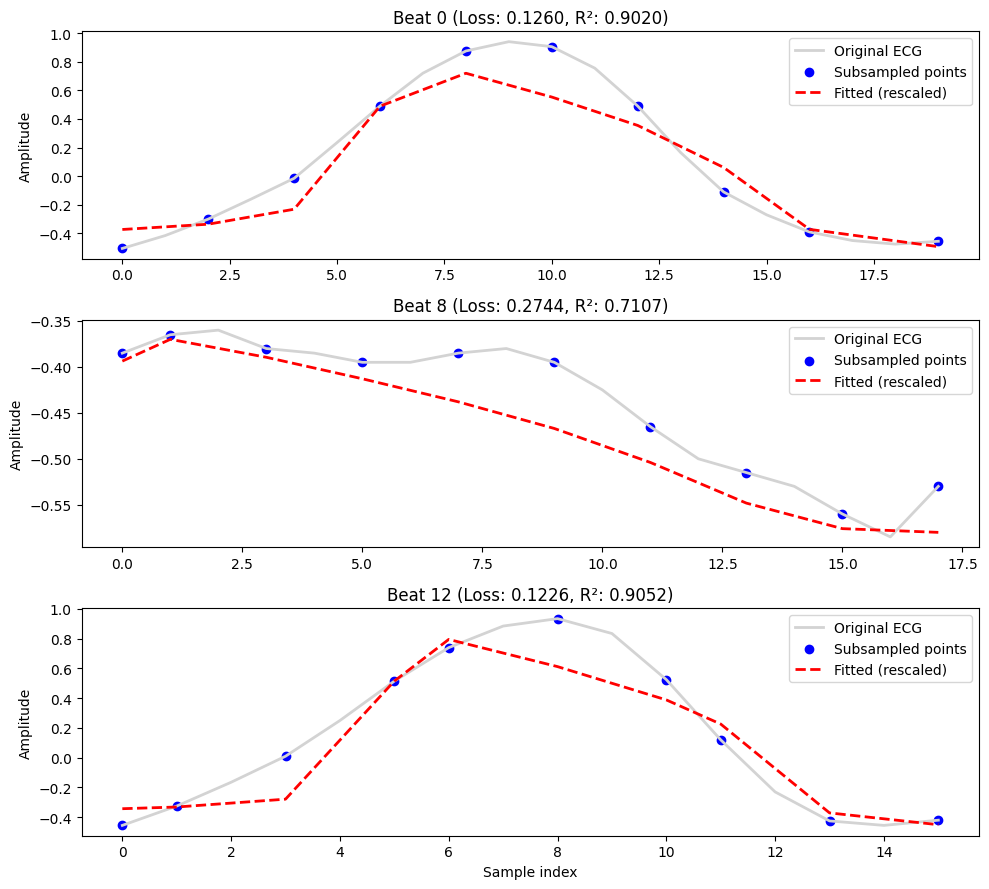

In [ ]:
beat_indices = [0, 8, 12] 
num_points = 10  # number of points to fit

fig, axes = plt.subplots(len(beat_indices), 1, figsize=(10, 3*len(beat_indices)))

for idx_plot, beat_idx in enumerate(beat_indices):
    q_idx = int(waves_df.iloc[beat_idx]["ECG_Q_Peaks"])
    s_idx = int(waves_df.iloc[beat_idx]["ECG_S_Peaks"])
    ecg_segment = ecg[q_idx:s_idx+1]
    t_segment = np.arange(len(ecg_segment))
    
    # Normalize beat for fitting
    ecg_min = np.min(ecg_segment)
    ecg_max = np.max(ecg_segment)
    ecg_norm = (ecg_segment - ecg_min) / (ecg_max - ecg_min)
    
    # Subsample normalized points
    indices = np.linspace(0, len(ecg_norm)-1, num_points, dtype=int)
    ecg_subsampled = ecg_norm[indices]
    t_subsampled = t_segment[indices]
    
    # Initial guess for FHN / AP using normalized u0
    params0 = [
        0.05,               # a
        5.0,                # k
        1.0,                # epsilon_low
        0.1,                # epsilon_high
        ecg_subsampled[0],  # u0 (adapted per beat)
        0.0                 # v0
    ]
    
    # Fit FHN / AP
    res = minimize(loss_ap, params0, args=(t_subsampled, ecg_subsampled), method='Nelder-Mead', bounds=bounds)
    fitted_params = res.x
    
    # Simulate fitted model
    v_fit_norm = simulate_ap(fitted_params, t_subsampled)
    
    # Rescale fitted signal back to original amplitude
    v_fit_rescaled = v_fit_norm * (ecg_max - ecg_min) + ecg_min
    
    # Compute metrics (on normalized scale)
    beat_loss = loss_ap(fitted_params, t_subsampled, ecg_subsampled)
    beat_r2 = r_squared(ecg_subsampled, v_fit_norm)
    
    # Plot
    ax = axes[idx_plot]
    ax.plot(t_segment, ecg_segment, color='lightgray', linewidth=2, label="Original ECG")
    ax.scatter(t_subsampled, ecg_segment[indices], color='blue', label="Subsampled points")
    ax.plot(t_subsampled, v_fit_rescaled, 'r--', linewidth=2, label="Fitted (rescaled)")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"Beat {beat_idx} (Loss: {beat_loss:.4f}, R²: {beat_r2:.4f})")
    ax.legend(loc='upper right')

    print(f"Fitted parameters for beat {beat_idx}: {fitted_params}")

axes[-1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()
